# 필요한 라이브러리 Import

In [2]:
!pip install kiwipiepy

In [3]:
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
kiwi=Kiwi()
stopwords =Stopwords()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import tensorflow as tf

In [5]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
import tensorflow as tf
tf.keras.backend.clear_session()

# Part | 데이터 concat 

In [8]:
## 파일 로드
path_aug = '~/aiffel/dktc/data_forder/all_data.csv' # 민준님이 역번역 증강 사용해서 train 합친거
path_sns= '~/aiffel/dktc/data_forder/sns_casual.csv' # 수연님이 sns_casual - 일반대화 합친거
path_bert= '~/aiffel/dktc/data_forder/BERT_augmented_result.csv'# 종환님이 진행한 bert augmentation
data_aug = pd.read_csv(path_aug)
data_bert = pd.read_csv(path_bert)
data_sns = pd.read_csv(path_sns)
data_sns = data_sns.sample(n=10000, random_state=42)

In [9]:
data = pd.concat([data_aug,data_sns,data_bert])

data.duplicated(subset=['conversation']).sum()

5292

In [10]:
data.drop_duplicates(inplace = True,subset=['conversation'])
data = data.drop(labels=['Unnamed: 0','idx'],axis=1)
data['class'].value_counts()

일반 대화          10896
기타 괴롭힘 대화       4909
갈취 대화           4657
직장 내 괴롭힘 대화     3733
협박 대화           3653
Name: class, dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27848 entries, 0 to 12849
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class         27848 non-null  object
 1   conversation  27848 non-null  object
dtypes: object(2)
memory usage: 652.7+ KB


# Part | 전처리 Class 

In [12]:
class TextProcessor:
    def __init__(self):
        self.kiwi = Kiwi()
        self.stopwords = Stopwords()
        
    # 데이터 정제 (불필요한 문자, 특수 문자, 이메일, URL, 자음/모음 등 제거)
    def clean_text(self, text):
        # E-mail 제거
        text = re.sub(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', '', text)
        # URL 제거
        text = re.sub(r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
        # 한글 자음, 모음 제거
        text = re.sub(r'([ㄱ-ㅎㅏ-ㅣ]+)', '', text)
        # 알파벳, 숫자 제거
        text = re.sub(r'([a-zA-Z0-9]+)', '', text)
        # HTML 태그 제거
        text = re.sub(r'<[^>]*>', '', text)
        # 특수 기호 제거
        text = re.sub(r'[^\w\s]', '', text)
        # 한글과 공백을 제외한 모든 문자 제거
        text = re.sub(r'[^가-힣\s]', '', text)
        # 다중 공백을 단일 공백으로
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    # 형태소 분석 및 불용어 제거
    def analyze_morphs(self, text):
        # 형태소 분석 수행 및 불용어 제거
        tokens = [(token.form,token.tag )for token in self.kiwi.tokenize(text, stopwords=self.stopwords)]
        return tokens
    
    # 'EF' 태그가 있는 형태소 제거
    def filter_ef_tag(self, tokens):
        # 'EF' 품사 태그가 있는 형태소 제거
        filtered_tokens = [token[0] for token in tokens if token[1] != 'EF']
        return filtered_tokens

    # 추가적인 단어 필터링
    def filter_specific_words(self, tokens):
        words_to_remove = ['ㅂ니다', '안', '야', '너', '키키', '키', '거', 'ㄴ가요', '습니다']
        filtered_tokens = [token for token in tokens if token not in words_to_remove]
        return filtered_tokens

    # 전체 과정 통합 (형태소 분석, EF 품사 및 불용어 제거)
    def process(self, text):
        cleaned_text = self.clean_text(text)
        tokens = self.analyze_morphs(cleaned_text)
        tokens_without_ef = self.filter_ef_tag(tokens)
        filtered_tokens = self.filter_specific_words(tokens_without_ef)
        return filtered_tokens

In [13]:
processor = TextProcessor()

data['ppc'] = data['conversation'].apply(lambda text: processor.process(text))

In [14]:
data[['conversation','ppc']].head(50)

,conversation,ppc
0,"지금 자살하고 싶으신가요?\n아니, 죄송해요.\n죽을 거면 혼자 죽는 거예요. 우리...","[지금, 자살, 싶, 으시, 아니, 죄송하, 어요, 죽, 혼자, 죽, 관여, ᆯ, ..."
1,여기는 길동 경찰서입니다.\n9시 40분에 마트에 폭발물을 설치하겠습니다.\n뭐라고...,"[여기, 길동, 경찰서, 시, 분, 마트, 폭발물, 설치, 뭐, 라고, 요, 다시,..."
2,"어떻게 지내셨나요? 장기를 잘 보관하고 계셨죠?\n네, 장기를 여기에 보관하는 것은...","[어떻, 지내, 시, 장기, 잘, 보관, 계시, 네, 장기, 여기, 보관, 이번, ..."
3,친구가 있는 곳으로 날려버리세요.\n정말 모르겠어요. 친구와 함께 달리고 있었는데 ...,"[친구, 곳, 날리, 버리, 세, 요, 정말, 모르, 친구, 함께, 달리, 는데, ..."
4,갚기\n돈이 없는데 어떻게 갚아요\n남의 돈을 빼앗고 여기는 희희낙낙입니다\n비용을...,"[갚, 기, 돈, 데, 어떻, 갚, 남, 돈, 빼앗, 여기, 희희낙낙, 비용, 지불..."
5,왜 나한테 그래요!!!\n나는이 사람을 사랑합니다. 헤어지자\n어떻게 나한테 이럴 ...,"[왜, 한테, 그렇, 사랑, 헤어지, 자, 어떻, 한테, 이렇, 있, 운명, ᆸ니다..."
6,가까이 오지 마세요! 가까이 오면 찌르겠습니다!\n살려주세요.\n진정하고 무기를 내...,"[가까이, 오, 말, 가까이, 오, 찌르, 살리, 진정하, 무기, 내려놓, 정말, ..."
7,"이걸 마시면 편안하게 죽을 수 있습니다\n살려주세요.\n아니, 당신은 나에게 죽은 ...","[이거, ᆯ, 마시, 편안, 죽, 있, 살리, 아니, 당신, 죽, 죄, 이상, 살,..."
8,왜 그래요? 이거 놔요\n가방을 주지 않으면 죽여버릴 것입니다\n진정하세요. 제가 ...,"[왜, 그렇, 이거, 놔요, 가방, 주, 으면, 죽이, 버리, 진정하, 저, 드리,..."
9,"간이 너무 큽니다. 어디가 눈에 띄겠어요!\n미주 엄마, 일주일만 더 사용하려고 했...","[간, 너무, 크, 어디, 눈, 띄, 미주, 엄마, 일, 주일, 사용, 려고, 하지..."


# Part | 빈도수 시각화

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_te

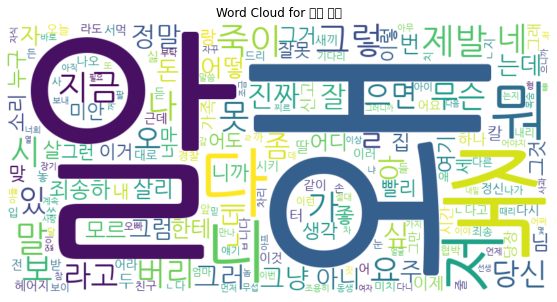

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_text(s, 0, flags=flags)


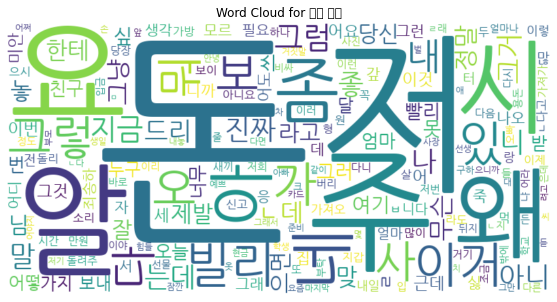

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 53440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47213 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 55192 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_

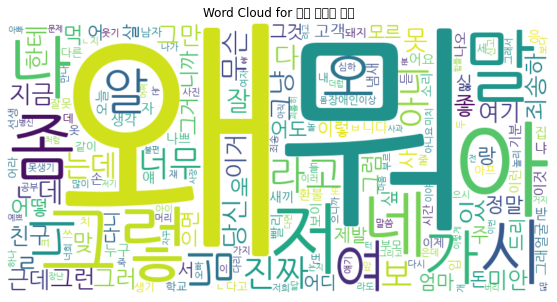

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 51649 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text

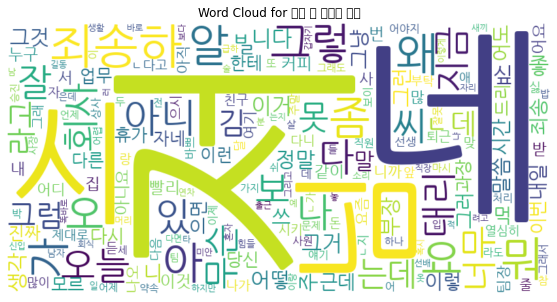

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)


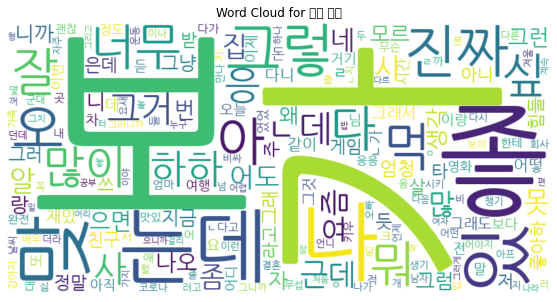

In [15]:
# 각 클래스별로 형태소 빈도 계산 및 시각화 준비
def visualize_class_wordcloud(df):
    classes = df['class'].unique()
    
    for class_name in classes:
        # 해당 클래스에 속하는 문장의 형태소 추출
        class_morphs = df[df['class'] == class_name]['ppc'].sum()  # 모든 형태소 리스트를 합침
        
        # 형태소 빈도 계산
        word_freq = Counter(class_morphs)
        
        # Word Cloud 생성
        wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', 
                              width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        
        # Word Cloud 시각화
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {class_name}')
        plt.show()

# WordCloud 시각화 실행
visualize_class_wordcloud(data)

In [16]:
# 나눔고딕 폰트 설치
!apt-get install -y fonts-nanum

# 설치된 나눔고딕 폰트를 matplotlib에 적용하기 위한 코드입니다.
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔고딕 폰트 경로를 가져와서 matplotlib에 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)
plt.rc('font', family=fontprop.get_name())  # 폰트 설정

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfcitx-u

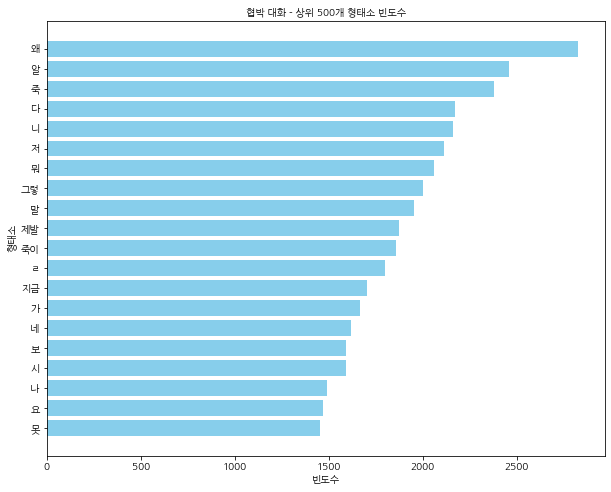

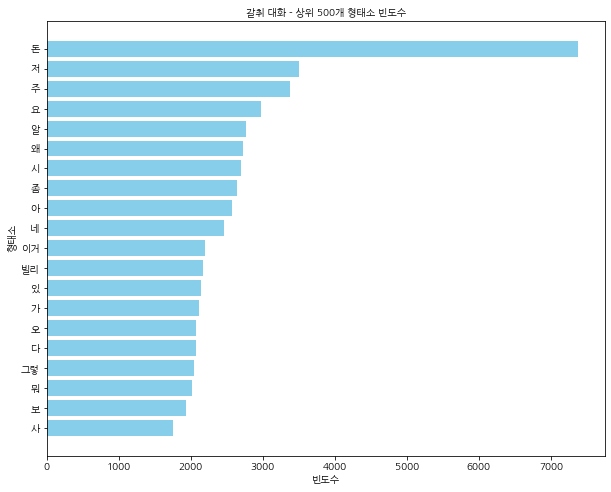

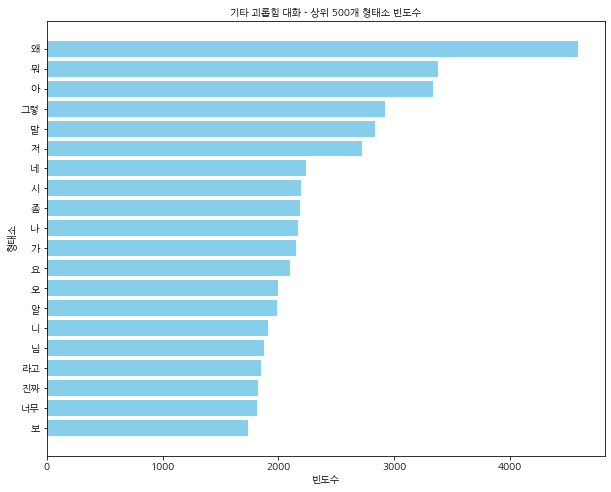

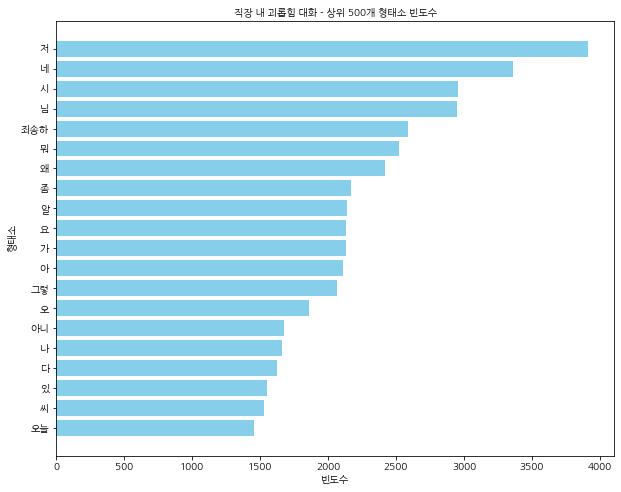

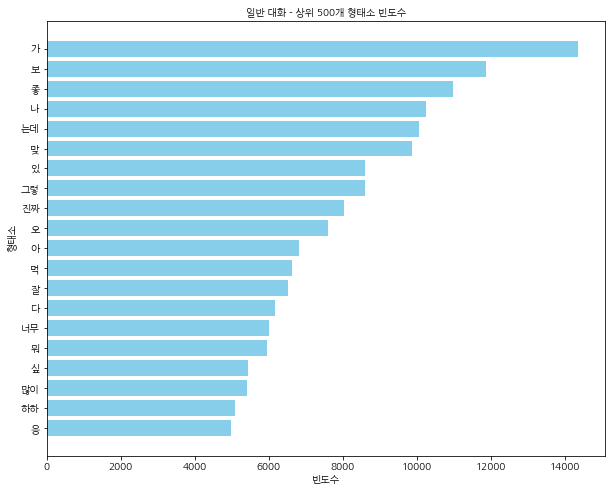

In [17]:
# 각 클래스별로 형태소 빈도 계산 및 시각화 준비
def visualize_class_barplot(df):
    classes = df['class'].unique()
    
    for class_name in classes:
        # 해당 클래스에 속하는 문장의 형태소 추출
        class_morphs = df[df['class'] == class_name]['ppc'].sum()  # 모든 형태소 리스트를 합침
        
        # 형태소 빈도 계산
        word_freq = Counter(class_morphs)
        
        # 상위 20개의 형태소만 추출
        most_common_20 = word_freq.most_common(20)
        
        # 형태소와 빈도 리스트 분리
        words, counts = zip(*most_common_20)
        
        # 바 그래프 생성
        plt.figure(figsize=(10, 8))
        plt.barh(words, counts, color='skyblue')
        plt.xlabel('빈도수')
        plt.ylabel('형태소')
        plt.title(f'{class_name} - 상위 500개 형태소 빈도수', fontproperties=fontprop)
        plt.gca().invert_yaxis()  # 가장 빈도가 높은 단어가 상단에 오도록
        plt.show()

# 바 그래프 시각화 실행
visualize_class_barplot(data)

In [18]:
data.head(50)

,class,conversation,ppc
0,협박 대화,"지금 자살하고 싶으신가요?\n아니, 죄송해요.\n죽을 거면 혼자 죽는 거예요. 우리...","[지금, 자살, 싶, 으시, 아니, 죄송하, 어요, 죽, 혼자, 죽, 관여, ᆯ, ..."
1,협박 대화,여기는 길동 경찰서입니다.\n9시 40분에 마트에 폭발물을 설치하겠습니다.\n뭐라고...,"[여기, 길동, 경찰서, 시, 분, 마트, 폭발물, 설치, 뭐, 라고, 요, 다시,..."
2,협박 대화,"어떻게 지내셨나요? 장기를 잘 보관하고 계셨죠?\n네, 장기를 여기에 보관하는 것은...","[어떻, 지내, 시, 장기, 잘, 보관, 계시, 네, 장기, 여기, 보관, 이번, ..."
3,협박 대화,친구가 있는 곳으로 날려버리세요.\n정말 모르겠어요. 친구와 함께 달리고 있었는데 ...,"[친구, 곳, 날리, 버리, 세, 요, 정말, 모르, 친구, 함께, 달리, 는데, ..."
4,협박 대화,갚기\n돈이 없는데 어떻게 갚아요\n남의 돈을 빼앗고 여기는 희희낙낙입니다\n비용을...,"[갚, 기, 돈, 데, 어떻, 갚, 남, 돈, 빼앗, 여기, 희희낙낙, 비용, 지불..."
5,협박 대화,왜 나한테 그래요!!!\n나는이 사람을 사랑합니다. 헤어지자\n어떻게 나한테 이럴 ...,"[왜, 한테, 그렇, 사랑, 헤어지, 자, 어떻, 한테, 이렇, 있, 운명, ᆸ니다..."
6,협박 대화,가까이 오지 마세요! 가까이 오면 찌르겠습니다!\n살려주세요.\n진정하고 무기를 내...,"[가까이, 오, 말, 가까이, 오, 찌르, 살리, 진정하, 무기, 내려놓, 정말, ..."
7,협박 대화,"이걸 마시면 편안하게 죽을 수 있습니다\n살려주세요.\n아니, 당신은 나에게 죽은 ...","[이거, ᆯ, 마시, 편안, 죽, 있, 살리, 아니, 당신, 죽, 죄, 이상, 살,..."
8,협박 대화,왜 그래요? 이거 놔요\n가방을 주지 않으면 죽여버릴 것입니다\n진정하세요. 제가 ...,"[왜, 그렇, 이거, 놔요, 가방, 주, 으면, 죽이, 버리, 진정하, 저, 드리,..."
9,협박 대화,"간이 너무 큽니다. 어디가 눈에 띄겠어요!\n미주 엄마, 일주일만 더 사용하려고 했...","[간, 너무, 크, 어디, 눈, 띄, 미주, 엄마, 일, 주일, 사용, 려고, 하지..."


In [19]:
df = data.copy()

# 레이블 인코딩
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화' : 4
}
df['class'] = df['class'].map(label_mapping)

In [20]:
# 토크나이저 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['ppc'])

# 시퀀스 인코딩
sequences = tokenizer.texts_to_sequences(df['ppc'])

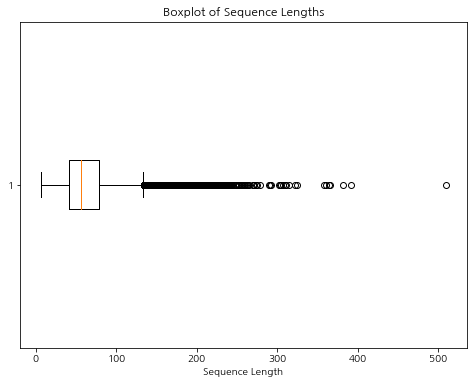

In [21]:
sequence_lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(8, 6))
plt.boxplot(sequence_lengths, vert=False)
plt.title('Boxplot of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.show()

In [60]:
# 최대 시퀀스 길이 결정 (% 로 결정)
max_seq_len = 40

In [61]:
# 패딩 적용
X = pad_sequences(sequences, maxlen=max_seq_len, padding='post')

# 레이블 준비
y = df['class'].values

In [62]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 검증 데이터를 8:2로 나눔 (클래스 비율을 유지)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

# 결과 확인
print(f"학습 데이터 크기: {X_train.shape}")
print(f"검증 데이터 크기: {X_val.shape}")

학습 데이터 크기: (22278, 40)
검증 데이터 크기: (5570, 40)


In [63]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 각도 계산
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 포지셔널 인코딩 계산
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스에는 cos 함수 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

In [64]:
# 패딩 마스크 생성 함수
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # (batch_size, 1, 1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [65]:
def scaled_dot_product_attention(q, k, v, mask):
    """ 스케일드 닷 프로덕트 어텐션 """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # Q와 K의 행렬 곱

    # 스케일링
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 마스크가 주어졌을 경우 -inf 적용
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax를 통해 attention weights 계산
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # attention weights와 V의 행렬곱
    output = tf.matmul(attention_weights, v)

    return output

In [66]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 가중치 행렬 정의
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """ 헤드 분할: [batch_size, seq_len, d_model] -> [batch_size, num_heads, seq_len, depth] """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        # 선형 변환
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # 헤드 분할
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention = scaled_dot_product_attention(q, k, v, mask)

        # 헤드 병합
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 선형 변환
        output = self.dense(concat_attention)

        return output

    def get_config(self):
        # 직렬화 지원을 위한 설정 저장
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 각도 계산
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 포지셔널 인코딩 계산
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스에는 cos 함수 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [67]:
# 인코더 레이어
def encoder_layer(units, d_model, num_heads, dropout_rate, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티 헤드 어텐션
    attention = MultiHeadAttention(d_model, num_heads)(inputs, inputs, inputs, padding_mask)
    attention = tf.keras.layers.Dropout(dropout_rate)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 네트워크
    outputs = tf.keras.layers.Dense(units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(d_model)(outputs)
    outputs = tf.keras.layers.Dropout(dropout_rate)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [68]:
# 인코더 전체
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout_rate,
            maximum_position_encoding,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 및 포지셔널 인코딩
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(maximum_position_encoding, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(dropout_rate)(embeddings)

    # 인코더 레이어 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout_rate=dropout_rate,
                                name=f"encoder_layer_{i}",
                                )(inputs=[outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [69]:
# 인코더 모델 생성
def build_encoder_model():
    inputs = tf.keras.Input(shape=(max_seq_len,), name="inputs")
    padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='padding_mask')(inputs)

    # 인코더 출력
    encoder_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout_rate=dropout_rate,
        maximum_position_encoding=max_seq_len,
        name="encoder"
    )(inputs=[inputs, padding_mask])

    # 글로벌 평균 풀링
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(encoder_outputs)

    # 출력 레이어 (다중 분류)
    outputs = tf.keras.layers.Dense(units=num_classes, activation='softmax', name='outputs')(pooled_output)

    # 모델 정의
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="transformer_classifier")

    return model

In [70]:
# 하이퍼파라미터 설정
vocab_size = len(tokenizer.word_index) + 1
num_layers = 2
d_model = 256
num_heads = 4
units = 512
dropout_rate = 0.4
num_classes = 5  # 클래스 수

In [71]:
# 모델 생성
model = build_encoder_model()

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "transformer_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 40)]         0                                            
__________________________________________________________________________________________________
padding_mask (Lambda)           (None, 1, 1, 40)     0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    9034240     inputs[0][0]                     
                                                                 padding_mask[0][0]               
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 256)          0           encoder[0][0

In [72]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='best_model', 
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# 추가적인 학습률 스케줄러 (선택 사항)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 모델 학습
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
697/697 [==============================] - 13s 16ms/step - loss: 0.6043 - accuracy: 0.7887 - val_loss: 0.3185 - val_accuracy: 0.9016

Epoch 00001: val_loss improved from inf to 0.31850, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


Epoch 2/20
697/697 [==============================] - 11s 15ms/step - loss: 0.2215 - accuracy: 0.9263 - val_loss: 0.2282 - val_accuracy: 0.9255

Epoch 00002: val_loss improved from 0.31850 to 0.22819, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


Epoch 3/20
697/697 [==============================] - 11s 15ms/step - loss: 0.1481 - accuracy: 0.9497 - val_loss: 0.2572 - val_accuracy: 0.9228

Epoch 00003: val_loss did not improve from 0.22819
Epoch 4/20
697/697 [==============================] - 11s 15ms/step - loss: 0.1258 - accuracy: 0.9551 - val_loss: 0.2515 - val_accuracy: 0.9285

Epoch 00004: val_loss did not improve from 0.22819

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/20
697/697 [==============================] - 11s 15ms/step - loss: 0.0697 - accuracy: 0.9751 - val_loss: 0.2350 - val_accuracy: 0.9391

Epoch 00005: val_loss did not improve from 0.22819
Epoch 6/20
697/697 [==============================] - 11s 16ms/step - loss: 0.0494 - accuracy: 0.9837 - val_loss: 0.2484 - val_accuracy: 0.9379

Epoch 00006: val_loss did not improve from 0.22819

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 7/20
697/697 [==============================] 

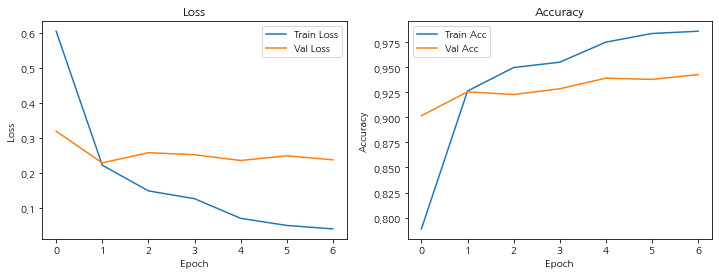

In [73]:
import matplotlib.pyplot as plt

# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [74]:
from sklearn.metrics import classification_report
from keras.models import load_model

# PositionalEncoding 클래스를 포함한 custom_objects 정의
custom_objects = {
    'MultiHeadAttention': MultiHeadAttention,
    'PositionalEncoding': PositionalEncoding
}

# SavedModel 형식으로 저장된 모델 불러오기
best_model = load_model('best_model', custom_objects=custom_objects)

# 검증 데이터에 대한 예측
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# 분류 보고서를 딕셔너리 형태로 얻기
report_dict = classification_report(y_val, y_pred_classes, target_names=label_mapping.keys(), output_dict=True)

# 딕셔너리를 DataFrame으로 변환
report_df = pd.DataFrame(report_dict).transpose()

# 필요한 컬럼만 선택하고 순서 지정
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]

# 소수점 자릿수 설정
report_df = report_df.round(4)

# 결과 확인
report_df

,precision,recall,f1-score,support
협박 대화,0.8626,0.9015,0.8816,731.0000
갈취 대화,0.9029,0.8690,0.8856,931.0000
직장 내 괴롭힘 대화,0.9441,0.9036,0.9234,747.0000
기타 괴롭힘 대화,0.8794,0.9134,0.8961,982.0000
일반 대화,0.9724,0.9706,0.9715,2179.0000
accuracy,0.9255,0.9255,0.9255,0.9255
macro avg,0.9123,0.9116,0.9116,5570.0000
weighted avg,0.9262,0.9255,0.9256,5570.0000


In [75]:
# 1. 테스트 데이터 로드
test_data_path = '~/aiffel/dktc/data_forder/test.csv'
test_df = pd.read_csv(test_data_path)

# 2. 전처리 객체 생성 및 테스트 데이터 전처리
test_df['ppc'] = test_df['text'].apply(lambda text: processor.process(text))
test_df['processed_text'] = test_df['ppc'].apply(lambda tokens: ' '.join(tokens))

# 3. 토큰화된 테스트 데이터 생성
tokenizer.fit_on_texts(df['ppc'])  # 훈련 데이터를 기반으로 토크나이저 적합
sequences_test = tokenizer.texts_to_sequences(test_df['processed_text'])
tokenized_test_data = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_seq_len, padding='post')

# 5. 모델 예측 수행
y_test_pred = best_model.predict(tokenized_test_data)

# 6. 예측 클래스 추출 및 threshold 적용
threshold =0.5 # 일반 대화로 분류할 확률 기준

# 기존 예측 결과에서 가장 높은 확률을 가진 클래스를 선택
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# 일반 대화의 확률이 threshold 이상인 경우 강제로 일반 대화(클래스 4)로 설정
for i in range(len(y_test_pred)):
    general_conversation_prob = y_test_pred[i, 4]  # 일반 대화 클래스(4)의 확률
    if general_conversation_prob >= threshold:
        y_test_pred_classes[i] = 4  # 일반 대화로 강제 분류
        
test_df['class'] = y_test_pred_classes    

# 8. 제출 파일 작성
submission = test_df[['idx', 'class']]
submission.columns = ['idx', 'target']
submission.to_csv('~/aiffel/dktc/data_forder/submission.csv', index=False)

In [76]:
test_df['class'].unique()

array([1, 2, 4, 3, 0])

In [77]:
test_df['class'].value_counts()

0    109
2    105
1    102
3     98
4     86
Name: class, dtype: int64

In [86]:
import pandas as pd

# 파일 경로에 맞게 수정해주세요
submission_13 = pd.read_csv('~/aiffel/dktc/result/submission (23).csv')
submission_15 = pd.read_csv('~/aiffel/dktc/result/submission (22).csv')

# target 값이 다른 항목 필터링
differences = submission_13[submission_13['target'] != submission_15['target']]

# 차이가 나는 idx 개수 출력
difference_count = differences.shape[0]

print(f"Target 값이 다른 idx 개수: {difference_count}")

Target 값이 다른 idx 개수: 102
